In [17]:
from transformers import AutoImageProcessor, AutoFeatureExtractor, TrOCRProcessor, VisionEncoderDecoderModel, DefaultDataCollator
import requests
from PIL import Image
import torch
from pathlib import Path
from datasets import Dataset, load_dataset
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
from matplotlib import pyplot as plt
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
import random
import pandas as pd


In [2]:
"""Create Dataset: Load images"""
IMAGES = '..\privateDir\example_images\segmented'
images_path = Path(IMAGES)

images_labels = {   '001': 'male',
                    '002': 'male',
                    '003': 'male',
                    '004': 'male',
                    '005': 'male',
                    '006': 'male',
                    '007': 'male',
                    '008': 'male',
                    '020' : 'female',
                    '021' : 'female',
                    '022' : 'female'}

In [ ]:
#LABELS = '..\privateDir\labels'
#labels_path = Path(LABELS)
#images_labels = pd.DataFrame(pd.read_csv(labels_path))

In [3]:
all_images = []
for idx, label in images_labels.items():
    for img_path in (images_path / idx).glob('*.jpeg'):
        all_images.append({ 'label': label, 'path': img_path })

print(all_images)

[{'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/001/001.jpeg')}, {'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/002/002.jpeg')}]


In [4]:
"""Create Dataset: Define IDs for target labels"""
labels = ['male', 'female', 'diverse']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]      = i
    id2label[i]     = label

print(label2id, id2label)

{'male': 0, 'female': 1, 'diverse': 2} {0: 'male', 1: 'female', 2: 'diverse'}


In [5]:
# _generator = ({'label': l['label'], 'image': Image.open(l['path'])} for l in all_images) 
#ds = Dataset.from_generator(_generator)
def _generator():
    for l in all_images:
        yield {'label': label2id[l['label']], 
               'image': Image.open(l['path'])}

ds=Dataset.from_generator(_generator)
ds = ds.train_test_split(test_size=0.2)

In [6]:
"""Preprocess Image"""

# Load Processor for ViT

CHECKPOINT="google/vit-base-patch16-224-in21k"
# Alternative: TrOCRProcessor.from_pretrained(CHECKPOINT).image_processor
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

(224, 224)
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


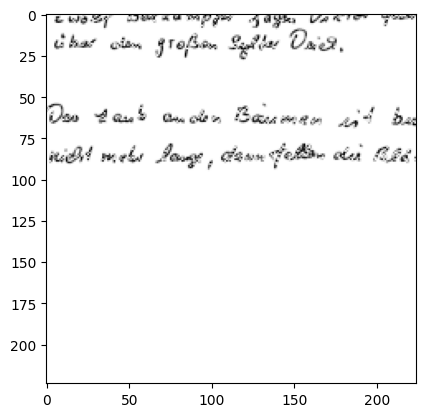

In [34]:
# Normalize Input Image
# evtl. use processor(img), but this returns an object with different dimensions
def tensor_to_image(t) -> Image:
    transform=ToPILImage()
    return transform(t)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
# in other processors, maybe use 'shortest_edge'
size = ( processor.size["height"], processor.size["width"] )
# JV suggests: do not normalize bc these are no food images
#_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
#_transforms = Compose([Resize(size), ToTensor(), normalize])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

print(size)
def transforms(examples):
    """Transform the image in the Dataset row."""
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

ds = ds.with_transform(transforms)
tensor = ds['train'][0]['pixel_values']
print(ds['train'][0]['pixel_values'])

img = tensor_to_image(tensor)
plt.imshow(img)
plt.show()

In [8]:
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # highest prediction per label index
    return accuracy.compute(predictions=predictions, references=labels)

In [9]:
model = AutoModelForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./local_checkpoints/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9373186230659485, 'eval_accuracy': 1.0, 'eval_runtime': 0.5526, 'eval_samples_per_second': 1.81, 'eval_steps_per_second': 1.81, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7734567523002625, 'eval_accuracy': 1.0, 'eval_runtime': 0.5874, 'eval_samples_per_second': 1.702, 'eval_steps_per_second': 1.702, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.603304386138916, 'eval_accuracy': 1.0, 'eval_runtime': 0.5447, 'eval_samples_per_second': 1.836, 'eval_steps_per_second': 1.836, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6359329223632812, 'eval_accuracy': 1.0, 'eval_runtime': 0.5307, 'eval_samples_per_second': 1.884, 'eval_steps_per_second': 1.884, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5699175596237183, 'eval_accuracy': 1.0, 'eval_runtime': 0.5187, 'eval_samples_per_second': 1.928, 'eval_steps_per_second': 1.928, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4695756733417511, 'eval_accuracy': 1.0, 'eval_runtime': 0.5235, 'eval_samples_per_second': 1.91, 'eval_steps_per_second': 1.91, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4375731647014618, 'eval_accuracy': 1.0, 'eval_runtime': 0.5251, 'eval_samples_per_second': 1.905, 'eval_steps_per_second': 1.905, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.39079204201698303, 'eval_accuracy': 1.0, 'eval_runtime': 0.5046, 'eval_samples_per_second': 1.982, 'eval_steps_per_second': 1.982, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.47226858139038086, 'eval_accuracy': 1.0, 'eval_runtime': 0.5271, 'eval_samples_per_second': 1.897, 'eval_steps_per_second': 1.897, 'epoch': 9.0}
{'loss': 0.1347, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.37578651309013367, 'eval_accuracy': 1.0, 'eval_runtime': 0.6087, 'eval_samples_per_second': 1.643, 'eval_steps_per_second': 1.643, 'epoch': 10.0}
{'train_runtime': 36.1867, 'train_samples_per_second': 0.276, 'train_steps_per_second': 0.276, 'train_loss': 0.13469496965408326, 'epoch': 10.0}


TrainOutput(global_step=10, training_loss=0.13469496965408326, metrics={'train_runtime': 36.1867, 'train_samples_per_second': 0.276, 'train_steps_per_second': 0.276, 'train_loss': 0.13469496965408326, 'epoch': 10.0})

In [13]:
classifier = pipeline("image-classification", model=model, image_processor=processor)

In [12]:
classifier = pipeline("image-classification", model=model, image_processor=processor)
males = [ l['path'] for  l in random.sample(all_images, len(all_images)) if l['label'] == 'male' ][:20]
for img in males:
    print(classifier(Image.open(img)))

[{'score': 0.3824424147605896, 'label': 'male'}, {'score': 0.3365170359611511, 'label': 'female'}, {'score': 0.2810405492782593, 'label': 'diverse'}]
[{'score': 0.39737528562545776, 'label': 'male'}, {'score': 0.30959898233413696, 'label': 'female'}, {'score': 0.2930257320404053, 'label': 'diverse'}]
